<a href="https://colab.research.google.com/github/kaival1524/Fake-News-Detection/blob/main/comp562fp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=True.csv

# Set ENV for kaggle auth
%env KAGGLE_USERNAME=maanavs
%env KAGGLE_KEY=b773082275687190d18a6b0e0de77c04

# Download dataset
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

api = KaggleApi()
api.authenticate()

!mkdir dataset
api.dataset_download_files("clmentbisaillon/fake-and-real-news-dataset")
with zipfile.ZipFile("fake-and-real-news-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

env: KAGGLE_USERNAME=maanavs
env: KAGGLE_KEY=b773082275687190d18a6b0e0de77c04


In [ ]:
import pandas as pd
import numpy as np


# Load csvs into pandas dfs
fake_df, true_df = pd.read_csv("dataset/Fake.csv"), pd.read_csv("dataset/True.csv")

# add classification field
fake_df['is_fake'] = 1
true_df['is_fake'] = 0


# Data visualization -- fetch first 10 entries from fake data
print("Top 10 entries from fake data")
print("Unique fake subjects:", true_df['subject'].unique())
fake_df.head(10)




Top 10 entries from fake data
Unique fake subjects: ['politicsNews' 'worldnews']


,title,text,subject,date,is_fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",1
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",1
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",1
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",1


In [ ]:
print("Top 10 entries from true data")
print("Unique subjects:", true_df['subject'].unique())
true_df.head(10)

Top 10 entries from true data
Unique subjects: ['politicsNews' 'worldnews']


,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",0
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",0
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",0
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",0
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",0


#Preprocessing

List of all preprocessing steps:

*   Map `subject` labels in Fake news set with the provided scheme
*   Add a binary field `is_fake` to both tables before concatinating
*   Compute sentiment of article title and body and add another field `sentiment`



By observing the unique subjects for both the fake and real news samples. It's clear that the categorical labels don't correspond. In it's current form this field won't be useful for prediction.

As a solution, after researching the scraping methodology and sources from the dataset. We've decided to use the following mapping to convert from
labels in the Fake news subject series to matching ones in the true series.

```
label_mp = {
    "News" : "worldnews",
    "politics" : "politicsnews",
    "left-news" : "politicsnews",
    "Government News": "politicsnews",
    "US_News": "politicsnews",
    "Middle-east": "worldnews",
}
```



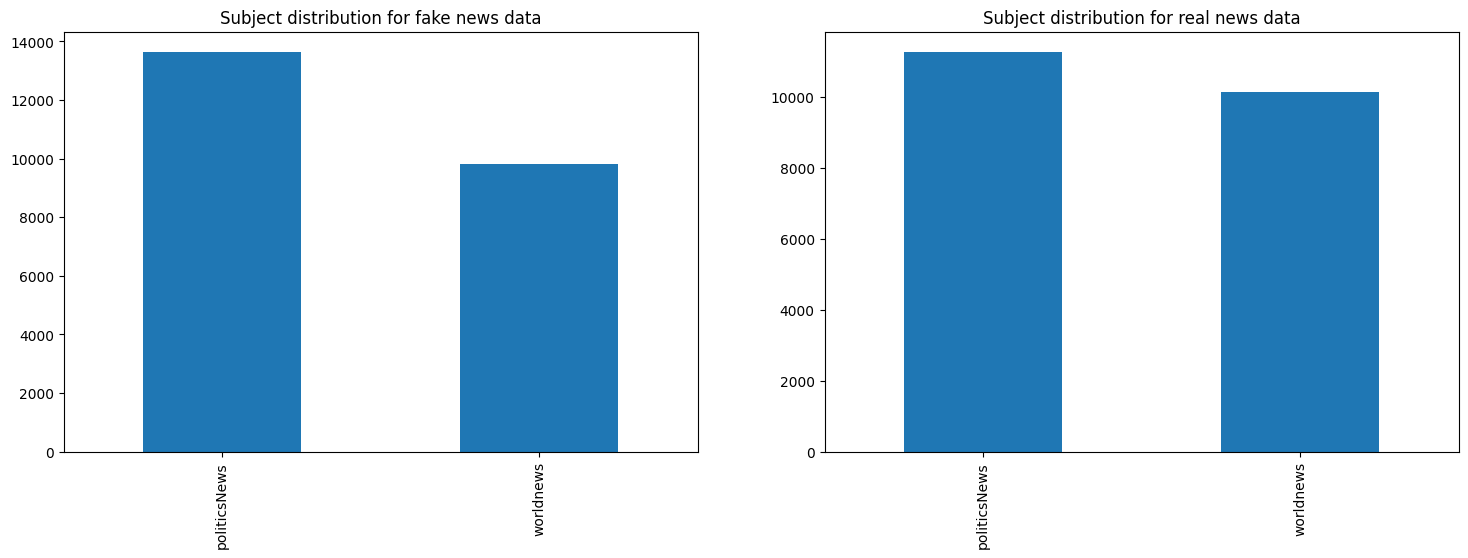

In [ ]:
# Plot distribution of news subjects
import matplotlib.pyplot as plt

# mapping fake categories to corresponding true categories
label_mp = {
    "News" : "worldnews",
    "politics" : "politicsNews",
    "left-news" : "politicsNews",
    "Government News": "politicsNews",
    "US_News": "politicsNews",
    "Middle-east": "worldnews",
    "worldnews": "worldnews", # these two lines add idempotency
    "politicsNews": "politicsNews"
}

numeric_mp = {
    'politicsNews' : 0,
    'worldnews': 1,
}

fake_df['subject'] = fake_df['subject'].map(label_mp)

fake_df['subject_num'] = fake_df['subject'].map(numeric_mp)
true_df['subject_num'] = true_df['subject'].map(numeric_mp)

plt.figure(figsize=(18,12))

plt.subplot(2, 2, 1)
plt.title("Subject distribution for fake news data")
ax = fake_df['subject'].value_counts().plot(kind='bar')

plt.subplot(2, 2, 2)
plt.title("Subject distribution for real news data")
true_df['subject'].value_counts().plot(kind='bar')
plt.show()

The date is a discrete time-series, in order for the model to be able to accept this the date must be converted into a numerical format. The date-string will be parsed, and attempted to be matched to the 3 present datetime formats.

If none of these patterns match, then the data is malformed and will be thrown out of the final clean dataset. To show this is a fair choice, the entries are printed below and clearly aren't well formed dates.

The correctly formed dates, after parsing, will be converted to epoch time. Due to the very large magnitude of these epoch times. The data will be normalized to ensure good performance and avoid large gradients in the model we design.

In [ ]:
# Both classes must be joined into one dataframe before normalization
news_df = pd.concat([fake_df, true_df])

# Best effort datetime format match
def strToEpoch(s):
  s = s.strip()
  try:
    x = datetime.strptime(s, "%B %d, %Y")
  except:
      try:
        x = datetime.strptime(s, "%d-%b-%y")
      except:
        try:
          x = datetime.strptime(s, "%b %d, %Y")
        except:
          print(f"NO MATCH FOUND FOR {s}")
          return None
  return x.timestamp()


# convert dates to epoch time and normalize
from datetime import datetime

print("Bad date entries to discard")
news_df['date'] = news_df['date'].map(strToEpoch)
news_df.dropna()

# normalize
dates = news_df['date']
news_df['date'] = (dates - dates.min()) / (dates.max() - dates.min())

news_df

Bad date entries to discard
NO MATCH FOUND FOR https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/
NO MATCH FOUND FOR https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/
NO MATCH FOUND FOR https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/
NO MATCH FOUND FOR https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
NO MATCH FOUND FOR https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
NO MATCH FOUND FOR https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
NO MATCH FOUND FOR https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
NO MATCH FOUND FOR MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]
NO MATCH FOUND FOR https://fed

,title,text,subject,date,is_fake,subject_num
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,worldnews,0.952652,1,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,worldnews,0.952652,1,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",worldnews,0.951705,1,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",worldnews,0.950758,1,1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,worldnews,0.946970,1,1
...,...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,0.828598,0,1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,0.828598,0,1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,0.828598,0,1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,0.828598,0,1


In [ ]:
news_df.describe()

,date,is_fake,subject_num
count,44888.000000,44898.000000,44898.000000
mean,0.635436,0.522985,0.444853
std,0.239775,0.499477,0.496955
min,0.000000,0.000000,0.000000
25%,0.441288,0.000000,0.000000
50%,0.667614,1.000000,0.000000
75%,0.859848,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [ ]:
import numpy as np
from scipy.stats import norm

def plot_histogram_with_pdf(x, s, xlabel="", ylabel="", title=""):
    plt.subplot(2, 2, s)

    # Calculate mean and standard deviation
    x_mean = x.mean()
    x_std = x.std()

    # Plot the histogram
    plt.hist(x, bins=17, density=True, alpha=0.6)

    # Create an x-axis for the curve
    x_axis = np.linspace(x.min(), x.max(), 100)

    # Generate the estimated PDF curve
    pdf = norm.pdf(x_axis, x_mean, x_std)

    # Plot the curve
    plt.plot(x_axis, pdf, 'k', linewidth=2)

    # Add lines for the mean and standard deviation
    plt.axvline(x=x_mean, color='r', linestyle='--', label='Mean')
    plt.axvline(x=x_mean + x_std, color='g', linestyle='--', label='Standard Deviation')
    plt.axvline(x=x_mean - x_std, color='g', linestyle='--')

    # Add axis labels and a title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.plot()


In [ ]:
from textblob import TextBlob
from tqdm import tqdm

tqdm.pandas()

'''
# Polarity: Measure contained within [-1, 1] representing negative (-1) and postive sentiment (1)
# Subjectivity: Measure contained within [0, 1] representing the amount of personal opinion (1) and factual information (0) in the text
'''

def compute_sentiment(row):
    classifier = TextBlob(row['title'] + ' ' + row['text'])
    row['polarity'] = classifier.sentiment.polarity
    row['subjectivity'] = classifier.sentiment.subjectivity
    return row

# drop duplicate entires before this time-intensive step
news_df.drop_duplicates()

# Add column to news_df with polarity and subjectivity
news_df = news_df.progress_apply(compute_sentiment, axis=1)




100%|██████████| 44898/44898 [02:57<00:00, 252.69it/s]


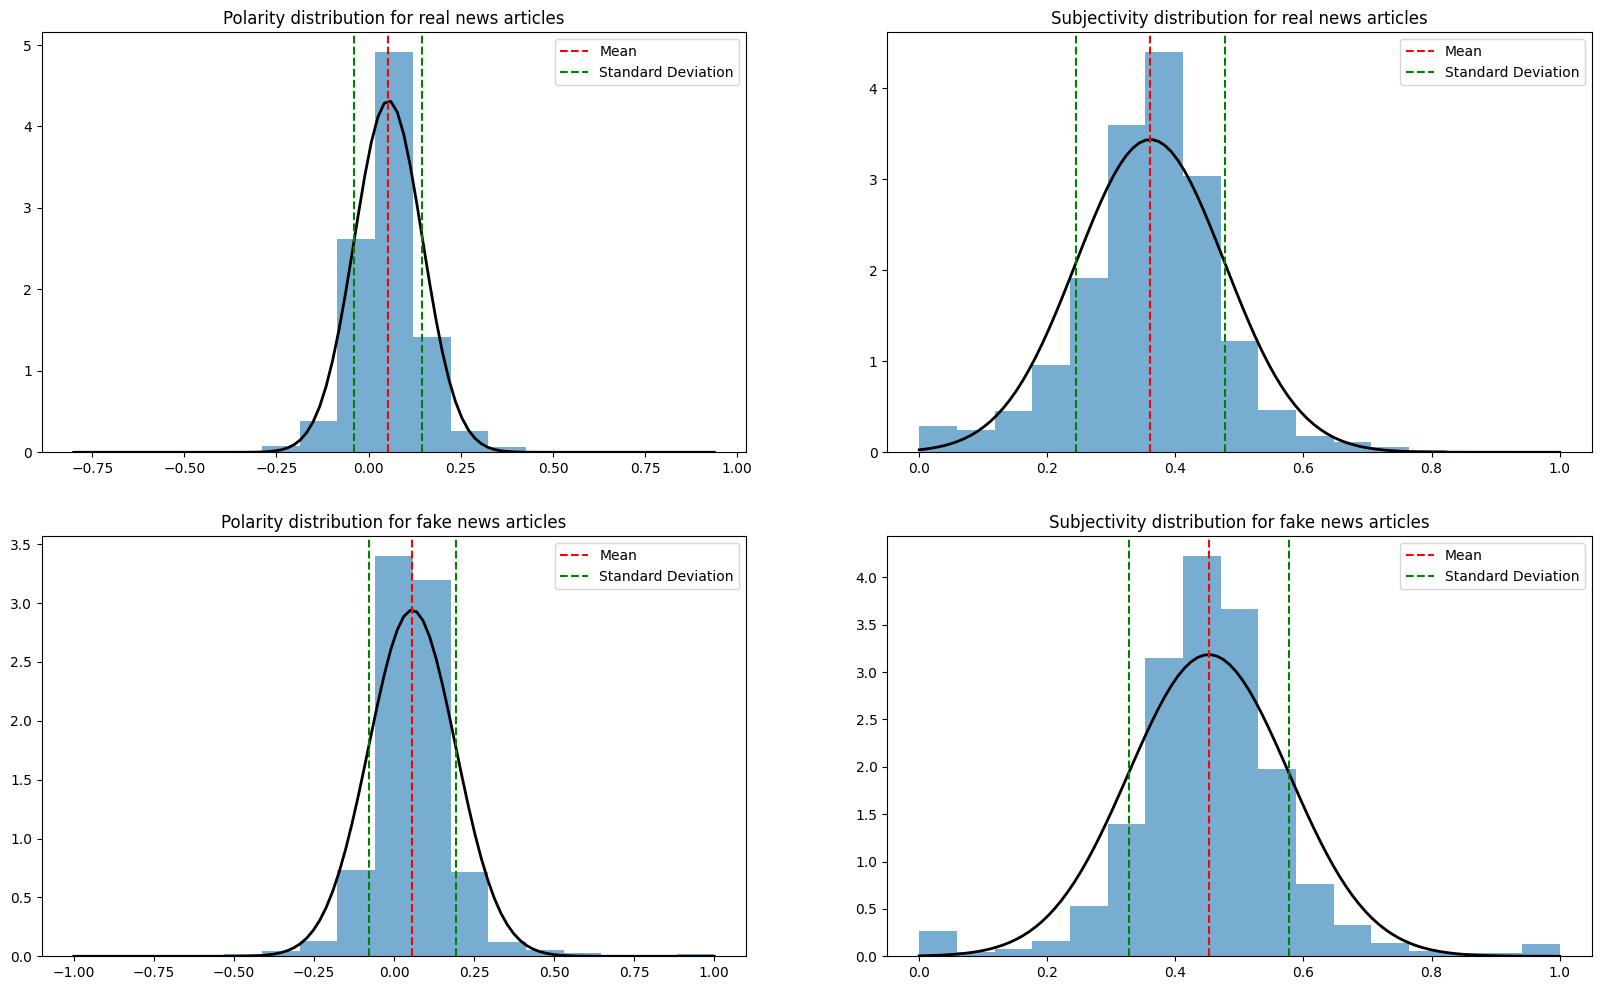

In [ ]:
plt.figure(figsize=(20,12))

plot_histogram_with_pdf(news_df['polarity'].loc[news_df['is_fake'] == 0], 1, title="Polarity distribution for real news articles")
plot_histogram_with_pdf(news_df['polarity'].loc[news_df['is_fake'] == 1], 3, title="Polarity distribution for fake news articles")
plot_histogram_with_pdf(news_df['subjectivity'].loc[news_df['is_fake'] == 0], 2, title="Subjectivity distribution for real news articles")
plot_histogram_with_pdf(news_df['subjectivity'].loc[news_df['is_fake'] == 1], 4, title="Subjectivity distribution for fake news articles")
plt.show()

In [ ]:
# Split data into training and validation after preprocessing
from sklearn.model_selection import train_test_split
training_split = .8

news_df_train, news_df_val = train_test_split(news_df, test_size=1-training_split, random_state=42)


print(f"Samples for training {len(news_df_train)}\nSamples for validation {len(news_df_val)}")

news_df_train.describe()

Samples for training 35918
Samples for validation 8980


,date,is_fake,subject_num,polarity,subjectivity
count,35910.000000,35918.000000,35918.000000,35918.000000,35918.000000
mean,0.636367,0.521967,0.443538,0.055195,0.408081
std,0.239571,0.499524,0.496809,0.116660,0.129238
min,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,0.443182,0.000000,0.000000,0.000000,0.340285
50%,0.669508,1.000000,0.000000,0.053900,0.409568
75%,0.859848,1.000000,1.000000,0.109091,0.479412
max,1.000000,1.000000,1.000000,1.000000,1.000000


#Model Design and Training:

The primary input feature used for creating effective classifications of an articicle is the title and actual body of the article: This is a very informationally dense format. Words in a sentence are dependant on each other bidirectionally and will only together determine the credibility of a news source.

To address these unique challenges, we will utilize a Recurrent Neural Network with Long Short Term Memory (LSTM)

Before the neural network is able to be fed text data, as well as the other columns of the current `news_df` dataframe.

We will need to:

1. Tokenize the words by enumerating the top 1k most frequent words (building a corpus of words)
2. Compute embeddings to convert aribitrary sequences of text tokens into a fixed size and lower-dimmensional vector. (Done automatically by tensorflow keras)

Both of these are neccesary steps to provide the neural network a well formed vector representation of the body of an article

In [ ]:
# tokenization hyperparameters
vocab_size = 5000
embedding_dim = 32
max_length = 100
trunc_type='post'
oov_tok=''

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Takes the string data and serializes it into a format able to be given to the model
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(news_df_train['text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(news_df_train['text'])
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(news_df_val['text'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, truncating=trunc_type)

In [ ]:
import tensorflow as tf

# text input -- compute embeddings and evaluate RNN
text_input = tf.keras.layers.Input(shape=(max_length,))
embeddings = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(text_input)
LSTM1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embeddings)
LSTM2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(LSTM1)
dense1 = tf.keras.layers.Dense(128, activation = 'relu')(LSTM2)
dense2 = tf.keras.layers.Dense(12, activation = 'relu')(dense1)

# numeric input -- encodes polarity, subjectivity, date, and category
numeric_input = tf.keras.layers.Input(shape=(3,))

merged = tf.keras.layers.Concatenate(axis=1)([dense2, numeric_input])
dense3 = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

model = tf.keras.models.Model(inputs=[text_input, numeric_input], outputs=dense3)



model.compile(loss ="binary_crossentropy", optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 32)      160000      ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 64)      16640       ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128)         66048       ['bidirectional[0][0]']          
 )                                                                                            

In [ ]:
tf.config.run_functions_eagerly(True)

numeric_inputs = np.array(list(zip(
    news_df_train['polarity'],
    news_df_train['subjectivity'],
    news_df_train['subject_num']
)))

numeric_inputs_val = np.array(list(zip(
    news_df_val['polarity'],
    news_df_val['subjectivity'],
    news_df_val['subject_num'],
)))

history = model.fit([padded, numeric_inputs], np.array(news_df_train['is_fake']), epochs=3, validation_data = ([validation_padded, numeric_inputs_val], np.array(news_df_val['is_fake'])))

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1123/1123 [==============================] - 174s 151ms/step - loss: 0.0448 - acc: 0.9814 - val_loss: 0.0196 - val_acc: 0.9947
Epoch 2/3
1123/1123 [==============================] - 178s 159ms/step - loss: 0.0078 - acc: 0.9983 - val_loss: 0.0032 - val_acc: 0.9996
Epoch 3/3
1123/1123 [==============================] - 169s 150ms/step - loss: 0.0033 - acc: 0.9994 - val_loss: 0.0032 - val_acc: 0.9993


  3/281 [..............................] - ETA: 9s 

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


281/281 [==============================] - 11s 39ms/step


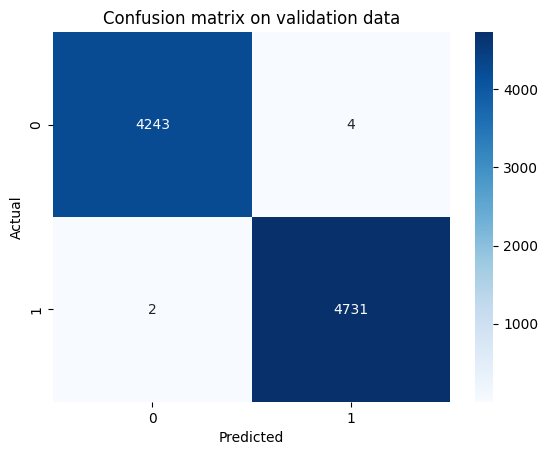

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the validation set
y_true = np.array(news_df_val['is_fake'])
y_pred = model.predict([validation_padded, numeric_inputs_val])
y_pred = (y_pred > 0.5).astype('int32')

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion matrix on validation data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# helper routine to inference one-off articles
def predict_article(title, text, is_political):
  sequences = tokenizer.texts_to_sequences([text])
  padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

  classifier = TextBlob(title + ' ' + text)
  pol = classifier.sentiment.polarity
  sub = classifier.sentiment.subjectivity

  numeric_inputs = [np.array([pol, sub, is_political])]

  return model.predict([padded, np.array(numeric_inputs)])[0][0]

In [ ]:
# Test with a 2023 current CNN article
article_title = "Sen. Dianne Feinstein’s husband dies after battle with cancer"
article_text = """Longtime Democratic Sen. Dianne Feinstein’s husband, Richard Blum, died Sunday evening following “a long battle with cancer,” according to an announcement from Feinstein’s office.
Feinstein, a California Democrat, said in a statement that her “heart is broken today.”
“My husband was my partner and best friend for more than 40 years,” she said. “He was by my side for the good times and for the challenges. I am going to miss him terribly.”
Blum died at the family’s home, the announcement from the senator’s office said. He was 86. Feinstein is 88 years old.
Senate Majority Leader Chuck Schumer, a New York Democrat, paid tribute to Blum and expressed condolences for Feinstein’s loss in a Senate floor speech on Monday.
Schumer called Blum a friend and adviser to “so many of us.”
“In his 86 years, Dick truly led a remarkable life. He was a force of nature, gifted with a winning smile, and keen intellect that he applied to the benefit of California, America and even international causes, including the American Himalayan Foundation because he cared so much about those folks,” he said.
Schumer recalled how Blum would call him “every now and then,” with his “insightful, often brilliant ideas.”
“The only problem was his enthusiasm was so intense, it was sometimes hard to get him off the phone,” he said.
“He was a strong and wonderful partner to Senator Feinstein,” Schumer said of Blum. “He fought valiantly against illness in the final chapters of his life, a life so well lived.”
"""
is_political = False


pred = predict_article(article_title, article_text, is_political)
print(f"\nReal Article Title: {article_title}\nReal Article Text: {article_text[:50] + '...'}\nis Political?: {is_political}")
print(f"Prediction (Is fake?): {bool(round(pred))}")

1/1 [==============================] - 0s 93ms/step

Real Article Title: Sen. Dianne Feinstein’s husband dies after battle with cancer
Real Article Text: Longtime Democratic Sen. Dianne Feinstein’s husban...
is Political?: False
Prediction (Is fake?): True


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
# Test with a modern current fake article
article_title = "Panicked King Charles III Flails Wildly After Getting Head Stuck Inside Coronation Crown"
article_text = """LONDON—Crashing through the stained glass window of Westminster Abbey in a desperate attempt to free himself, a panicked King Charles III was seen flailing wildly Saturday after getting his head stuck inside the coronation crown.
“Help! Help! Get me out of this godforsaken crown this instant!” said the king, who tried to use his jewel-encrusted scepter to pry off St. Edward’s Crown before accidentally getting his pants caught on a pulley that hoisted him onto the face of Big Ben, exposing his heart-patterned boxers for the entire kingdom to see.
“Ow, it hurts! Butter, I need butter! Obey your king’s command for more butter! Whoop whoop whoop whoop whoop!” At press time, Prince William reportedly attempted to free his father by cutting his head off with a sword.
"""
is_political = True


pred = predict_article(article_title, article_text, is_political)
print(f"\nFake Article Title: {article_title}\nFake Article Text: {article_text[:50] + '...'}\nis Political?: {is_political}")
print(f"Prediction (Is fake?): {bool(round(pred))}")

1/1 [==============================] - 0s 84ms/step

Fake Article Title: Panicked King Charles III Flails Wildly After Getting Head Stuck Inside Coronation Crown
Fake Article Text: LONDON—Crashing through the stained glass window o...
is Political?: True
Prediction (Is fake?): True
